In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

#define file path and read the file with geopandas

fp = r"C:\Users\admin\geopython\L4\L4_Data\corine_tartu.shp"

data = gpd.read_file(fp)

data.head(5)

code_12          ID Remark    Area_Ha   Shape_Leng     Shape_Area  \
0     111  EU-2024275   None  51.462132  4531.639281  514621.315450   
1     112  EU-2024328   None  25.389164   143.790405     153.109311   
2     112  EU-2024336   None  28.963212  2974.801106  289632.119850   
3     112  EU-2024348   None  54.482860  5546.791914  544828.603299   
4     112  EU-2024352   None  33.392926  4102.166244  333929.262851   

                                            geometry  
0  POLYGON Z ((5290566.200000002 4034511.45 0, 52...  
1  (POLYGON Z ((5259932.400000001 3993825.37 0, 5...  
2  POLYGON Z ((5268691.710000002 3996582.90000000...  
3  POLYGON Z ((5270008.730000001 4001777.44000000...  
4  POLYGON Z ((5278194.410000001 4003869.23000000...

In [12]:
# define corine legend file to be joined

import pandas as pd
fp_cl =r"C:\Users\admin\geopython\L4\L4_Data\corine_legend\clc_legend.csv"

#alwasy check column seperator
leg = pd.read_csv(fp_cl,sep=';',encoding='latin1')

leg.head(5)


GRID_CODE  CLC_CODE                                      LABEL3  \
0          1       111                     Continuous urban fabric   
1          2       112                  Discontinuous urban fabric   
2          3       121              Industrial or commercial units   
3          4       122  Road and rail networks and associated land   
4          5       123                                  Port areas   

           RGB,,  
0  230-000-077,,  
1  255-000-000,,  
2  204-077-242,,  
3  204-000-000,,  
4  230-204-204,,

In [13]:
display(data.dtypes)
display(leg.dtypes)

code_12        object
ID             object
Remark         object
Area_Ha       float64
Shape_Leng    float64
Shape_Area    float64
geometry       object
dtype: object

GRID_CODE     int64
CLC_CODE      int64
LABEL3       object
RGB,,        object
dtype: object

In [14]:
def change_type(row):
    code_as_int = int(row['code_12'])
    return code_as_int

data['clc_code_int'] = data.apply(change_type, axis=1)


In [17]:
data.head(2)

#check the data type of the new column created

display(data["clc_code_int"].dtypes)

dtype('int64')

In [18]:
data = data.merge(leg, how='inner', left_on='clc_code_int', right_on='CLC_CODE', suffixes=('', '_legend'))

In [19]:
data.head(2)

code_12          ID Remark    Area_Ha   Shape_Leng     Shape_Area  \
0     111  EU-2024275   None  51.462132  4531.639281  514621.315450   
1     112  EU-2024328   None  25.389164   143.790405     153.109311   

                                            geometry  clc_code_int  GRID_CODE  \
0  POLYGON Z ((5290566.200000002 4034511.45 0, 52...           111          1   
1  (POLYGON Z ((5259932.400000001 3993825.37 0, 5...           112          2   

   CLC_CODE                      LABEL3          RGB,,  
0       111     Continuous urban fabric  230-000-077,,  
1       112  Discontinuous urban fabric  255-000-000,,

In [23]:
#lways check column names

selected_cols = ['ID','Remark','Shape_Area','CLC_CODE','LABEL3','RGB,,','geometry']
data = data[selected_cols]
data.columns



Index(['ID', 'Remark', 'Shape_Area', 'CLC_CODE', 'LABEL3', 'RGB,,',
       'geometry'],
      dtype='object')

In [24]:
data_proj = data.to_crs(epsg=3301)

In [25]:
data_proj['area'] = data_proj.area

In [26]:
data_proj['area'].head(2)

0    514565.037796
1       153.104211
Name: area, dtype: float64

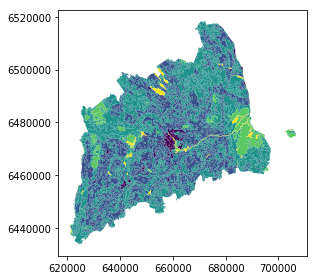

In [27]:
data_proj.plot(column='CLC_CODE', linewidth=0.05)
# Use tight layout and remove empty whitespace around our map
plt.tight_layout()

In [ ]:
#data["col"].unique()


In [28]:
# Select bogs (i.e. 'Peat bogs' in the data) and make a proper copy out of our data
bogs = data_proj.loc[data_proj['LABEL3'] == 'Peat bogs'].copy()

In [29]:
bogs.head(2)

ID Remark    Shape_Area  CLC_CODE     LABEL3          RGB,,  \
2214  EU-2056784   None  4.772165e+05       412  Peat bogs  077-077-255,,   
2215  EU-2056806   None  8.917057e+06       412  Peat bogs  077-077-255,,   

                                               geometry          area  
2214  POLYGON Z ((625609.433341943 6453543.494989649...  4.771837e+05  
2215  POLYGON Z ((631620.6205747491 6465132.49046137...  8.916207e+06

In [30]:
bogs['area_km2'] = bogs['area'] / 1000000

l_mean_size = bogs['area_km2'].mean()

l_mean_size



2.155588679444154

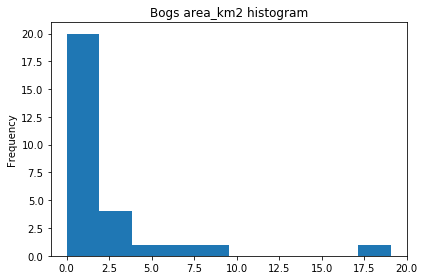

In [36]:
fig, ax = plt.subplots()

bogs['area_km2'].plot.hist(bins=10);

# Add title
plt.title("Bogs area_km2 histogram")
#Text(0.5, 1.0, 'Bogs area_km2 histogram')

plt.tight_layout()

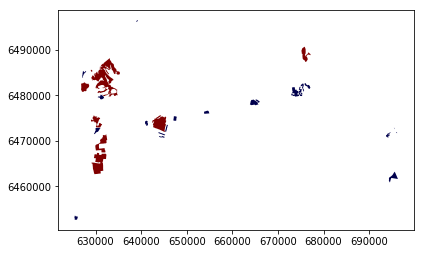

In [41]:
    def binaryClassifier(row, source_col, output_col, threshold):
        # If area of input geometry is lower that the threshold value
        if row[source_col] < threshold:
            # Update the output column with value 0
            row[output_col] = 0
        # If area of input geometry is higher than the threshold value update with value 1
        else:
            row[output_col] = 1
        # Return the updated row
        return row

#classification column

bogs['small_big'] = None

bogs = bogs.apply(binaryClassifier, source_col='area_km2', output_col='small_big', threshold=l_mean_size, axis=1)

bogs.head(5)

bogs.plot(column='small_big', linewidth=0.05, cmap="seismic")

plt.tight_layout()

In [42]:
outfp_bogs = r"C:\Users\admin\geopython\L4\bogs.shp"
bogs.to_file(outfp_bogs)

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt

# File path
fp = r"C:\Users\admin\geopython\L4\L4_Data\population_admin_units.shp"
acc = gpd.read_file(fp)


import pysal as ps

# Define the number of classes
n_classes = 5
    
classifier = ps.Natural_Breaks.make(k=n_classes)

C:\Users\admin\Miniconda3\envs\geopython-environment\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [45]:
acc.dtypes

VID           float64
KOOD           object
NIMI           object
population     object
geometry       object
dtype: object

In [46]:
#to_numeric can do same under pandas or geopandas
import numpy as np

def change_type_defensively(row):
    
    try:
        return int(row['population'])
    except Exception:
        return np.nan
    
acc['population_int'] = acc.apply(change_type_defensively, axis=1)
acc.head(5)

VID  KOOD          NIMI population  \
0  41158132.0  0698    Rõuge vald       5435   
1  41158133.0  0855    Valga vald      15989   
2  41158134.0  0732  Setomaa vald       3369   
3  41158135.0  0917     Võru vald      10793   
4  41158136.0  0142   Antsla vald       4514   

                                            geometry  population_int  
0  POLYGON ((646935.772312 6394632.93974981, 6470...            5435  
1  POLYGON ((620434.775846644 6406412.85221975, 6...           15989  
2  (POLYGON ((698977.67655779 6412793.36230097, 6...            3369  
3  POLYGON ((656207.140703753 6413138.43813412, 6...           10793  
4  POLYGON ((640706.698387788 6417414.06838516, 6...            4514

In [47]:
acc['population_classes'] = acc[['population_int']].apply(classifier)

In [48]:
acc.head()

VID  KOOD          NIMI population  \
0  41158132.0  0698    Rõuge vald       5435   
1  41158133.0  0855    Valga vald      15989   
2  41158134.0  0732  Setomaa vald       3369   
3  41158135.0  0917     Võru vald      10793   
4  41158136.0  0142   Antsla vald       4514   

                                            geometry  population_int  \
0  POLYGON ((646935.772312 6394632.93974981, 6470...            5435   
1  POLYGON ((620434.775846644 6406412.85221975, 6...           15989   
2  (POLYGON ((698977.67655779 6412793.36230097, 6...            3369   
3  POLYGON ((656207.140703753 6413138.43813412, 6...           10793   
4  POLYGON ((640706.698387788 6417414.06838516, 6...            4514   

   population_classes  
0                   0  
1                   2  
2                   0  
3                   1  
4                   0

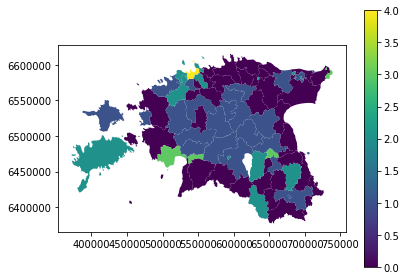

In [49]:
acc.plot(column="population_classes", linewidth=0, legend=True);

plt.tight_layout()

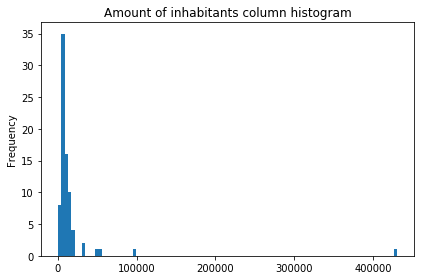

In [50]:
fig, ax = plt.subplots()

acc["population_int"].plot.hist(bins=100);

# Add title
plt.title("Amount of inhabitants column histogram")
#Text(0.5, 1.0, 'Amount of inhabitants column histogram')

plt.tight_layout()

In [51]:
grouped = acc.groupby('population_classes')

# legend_dict = { 'class from to' : 'white'}
legend_dict = {}

for cl, valds in grouped:
    minv = valds['population_int'].min()
    maxv = valds['population_int'].max()
    print("Class {}: {} - {}".format(cl, minv, maxv))

Class 0: 141 - 7506
Class 1: 7613 - 13685
Class 2: 14084 - 34394
Class 3: 50403 - 96506
Class 4: 430805 - 430805


In [52]:
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt

import collections

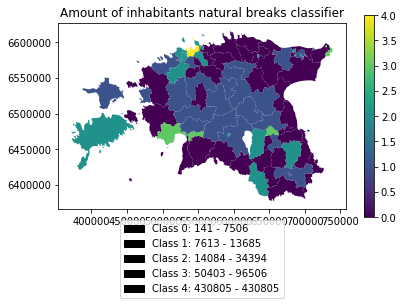

In [56]:
# legend_dict, a special ordered dictionary (which reliably remembers order of adding things) that holds our class description and gives it a colour on the legend (we leave it "background" white for now)
legend_dict = collections.OrderedDict([])

for cl, valds in grouped:
    minv = valds['population_int'].min()
    maxv = valds['population_int'].max()
    legend_dict.update({"Class {}: {} - {}".format(cl, minv, maxv): "black"})
    
fig, ax = plt.subplots()

# plot the dataframe, with the natural breaks colour scheme
acc.plot(ax=ax, column="population_classes", linewidth=0, legend=True);

# the custom "patches" per legend entry of our additional labels
patchList = []

for key in legend_dict:
    data_key = mpatches.Patch(color=legend_dict[key], label=key)
    patchList.append(data_key)


# plot the custom legend
plt.legend(handles=patchList, loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=1)


# Add title
plt.title("Amount of inhabitants natural breaks classifier")


In [58]: plt.tight_layout()

SyntaxError: invalid syntax (<ipython-input-62-bf11f35e1902>, line 9)